In [1]:
"""
Purpose: To download the best model from training
and to process test images and visualize

Pseudocode:
----- parameter config
- sets up parameters for things like:
    a. where test data input directory is
    b. whether to download best experiments

----- Step 1: Import and Preprcoes data
1) gets input data filename
2) Creates a composition of the transforms to be used on dataset
3) builds the dataset object
4) builds the dataloader

----- Step 2: Model
5) Configures neptune settings
6) gets parameter properties and settings
7) If downloading:
    use neptune download artifact to get details
   If not downloading: load the model filepath
7 output: a dictionary called model_state_dict

8) create an random parameter model architecture from function using:
- model weights pulled from neptune

9) Loads the model weights into the model from model_state_dict

----- Step 3: Inference
10) puts the model in eval mode
Iterates through the data loader:
a. run prediction of model
b. saves current prediction as json to path

----- Step 4: Visualizing predictions
11) gets all the prediction files
12) Creates transforms for prediction dataset:
- applies normalization, nms , score thresholding
13) Creates prediction dataset

14) Runs the viewer
"""


' \nPurpose: To download the best model from training\nand to process test images and visualize\n\nPseudocode: \n----- parameter config\n- sets up parameters for things like:\n    a. where test data input directory is\n    b. whether to download best experiments\n\n----- Step 1: Import and Preprcoes data\n1) gets input data filename\n2) Creates a composition of the transforms to be used on dataset\n3) builds the dataset object\n4) builds the dataloader\n\n----- Step 2: Model\n5) Configures neptune settings \n6) gets parameter properties and settings\n7) If downloading:\n    use neptune download artifact to get details\n   If not downloading: load the model filepath\n7 output: a dictionary called model_state_dict\n\n8) create an random parameter model architecture from function using:\n- model weights pulled from neptune\n\n9) Loads the model weights into the model from model_state_dict\n\n----- Step 3: Inference\n10) puts the model in eval mode\nIterates through the data loader:\na. ru

In [2]:
%load_ext autoreload
%autoreload 2

# Necessary Modules

In [3]:
# %%shell

# #missing packages
# pip3 install pytorch-lightning
# pip3 install importlib-metadata
# pip3 install pydantic[dotenv]
# pip3 install -U 'neptune-client'


# cd /content
# git clone https://github.com/bacelii/python_tools.git
# pip3 install -e python_tools
# pip3 install -e /content/drive/MyDrive/Grad_Classes/Hike/object_detection_utils/

In [43]:
import ast
import os
import pathlib
from dataclasses import asdict, dataclass, field
from typing import Dict, List, Optional, Tuple

import neptune
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection.transform import GeneralizedRCNNTransform

from object_detection_utils.backbone_resnet import ResNetBackbones
from object_detection_utils.datasets import (
    ObjectDetectionDataSet,
    ObjectDetectionDatasetSingle,
)
from object_detection_utils.faster_RCNN import get_faster_rcnn_resnet
from object_detection_utils.transformations import (
    ComposeDouble,
    ComposeSingle,
    FunctionWrapperDouble,
    FunctionWrapperSingle,
    apply_nms,
    apply_score_threshold,
    normalize_01,
)
from object_detection_utils.utils import (
    collate_single,
    get_filenames_of_path,
    save_json,
)



# Configuring paraemeters and loggers

In [20]:
# Data configuration
from pathlib import Path
ROOT_PATH = Path("/content/drive/MyDrive/Grad_Classes/Hike/object_detection_utils/Applications/foot_faster_rcnn")
print(f"ROOT_PATH exists? {ROOT_PATH.exists()}")

#ROOT_PATH: Path = Path(__file__).parent.absolute()
checkpoint_dir: Path = (
    ROOT_PATH  / Path("model_checkpoints")
)
checkpoint_dir
checkpoint_dir.mkdir(exist_ok=True)

data_path: Path = (
    ROOT_PATH / Path("data/test/images")
)

print(f"data_path exists? {data_path.exists()}")

pred_path: Path = (
    ROOT_PATH / Path("data/pred")
)

pred_path.mkdir(exist_ok = True)


ROOT_PATH exists? True
data_path exists? True


In [74]:
mapping: Dict[str, int] = {
    "T1": 1,
    "T2": 2,
    "T3":3,
    "T4": 4,
    "T5": 5,
    "MT1":6,
    "MT5":7,
    "CBL":8,
    "CBR":9,
    "CTL":10,
    "CTR":11
}

@dataclass
class Parameters:
    """
    Dataclass for the parameters.
    """

    BATCH_SIZE: int = 2
    CACHE: bool = True
    DATA_DIR: Optional[str] = str(data_path.absolute())
    PRED_DIR:  Optional[str] = str(pred_path.absolute())
    MODEL_DIR = str((checkpoint_dir / Path('best_model.pt')).absolute())

    CLASSES: int = len(mapping) + 1 # adds on for the base class
    BACKBONE: ResNetBackbones = ResNetBackbones.RESNET34
    FPN: bool = False
    ANCHOR_SIZE: Tuple[Tuple[int, ...], ...] = ((32, 64, 128, 256, 512),)
    ASPECT_RATIOS: Tuple[Tuple[float, ...]] = ((0.5, 1.0, 2.0),)

    MIN_SIZE: int = 1024
    MAX_SIZE: int = 1025
    IMG_MEAN: List = field(default_factory=lambda: [0.485, 0.456, 0.406])
    IMG_STD: List = field(default_factory=lambda: [0.229, 0.224, 0.225])

    iou_threshold = 0.1
    score_threshold = 0.5

parameters = Parameters()

In [22]:
from pydantic import BaseSettings, Field
class NeptuneSettings(BaseSettings):
    """
    Reads the variables from the environment.
    Errors will be raised if the required variables are not set.
    """
    api_key: str = Field(env="NEPTUNE")
    OWNER: str = "brendanacelii"  # set your name here, e.g. johndoe22
    PROJECT: str = "Object-Detection-FasterRCNN"  # set your project name here, e.g. Heads
    EXPERIMENT: str = "complete-retrain"  # set your experiment name here, e.g. heads

    class Config:
        # this tells pydantic to read the variables from the .env file
        env_file = str((ROOT_PATH / Path(".env")).absolute())


# ----- Step 1: Import and Preprcoes data

In [24]:
inputs = get_filenames_of_path(pathlib.Path(parameters.DATA_DIR))
inputs.sort()

In [25]:
transforms = ComposeSingle(
    [
        FunctionWrapperSingle(np.moveaxis, source=-1, destination=0),
        FunctionWrapperSingle(normalize_01),
    ]
)


# %%
# create dataset
dataset = ObjectDetectionDatasetSingle(
    inputs=inputs,
    transform=transforms,
    use_cache=False,
)


# %%
# create dataloader
dataloader_prediction = DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_single,
)


# ----- Step 2: Model Creation (load with same parameters and architecture)

In [41]:
# import neptune.legacy as neptune

# neptune_settings: NeptuneSettings = NeptuneSettings()
# neptune_settings

# project_name = f'{neptune_settings.OWNER}/{neptune_settings.PROJECT}'
# project = neptune.init(
#     project=project_name, api_token=neptune_settings.api_key
# )  # get project
# experiment_id = neptune_settings.EXPERIMENT # experiment id
# experiment = project.get_experiments(id=experiment_id)[0]
# parameters = experiment.get_parameters()
# properties = experiment.get_properties()


In [51]:
transform = GeneralizedRCNNTransform(
    min_size=int(parameters.MIN_SIZE),
    max_size=int(parameters.MAX_SIZE),
    image_mean=parameters.IMG_MEAN,
    image_std=parameters.IMG_STD,
)

In [55]:
model_state_dict = torch.load(parameters.MODEL_DIR, map_location=torch.device("cpu"))
#model_state_dict = checkpoint["hyper_parameters"]["model"].state_dict()

In [58]:
model = get_faster_rcnn_resnet(
    num_classes=int(parameters.CLASSES),
    backbone_name=ResNetBackbones(parameters.BACKBONE),  # reverse look-up enum
    anchor_size=parameters.ANCHOR_SIZE,
    aspect_ratios=parameters.ASPECT_RATIOS,
    fpn=parameters.FPN,
    min_size=int(parameters.MIN_SIZE),
    max_size=int(parameters.MAX_SIZE),
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


In [59]:
model.load_state_dict(model_state_dict)

<All keys matched successfully>

# ----- Step 3: Inference

In [62]:
model.eval()
for sample in dataloader_prediction:
    x, x_name = sample
    with torch.no_grad():
        pred = model(x)
        pred = {key: value.numpy() for key, value in pred[0].items()}
        name = pathlib.Path(x_name[0])
        save_dir = Path(parameters.PRED_DIR)
        save_dir.mkdir(parents=True, exist_ok=True)
        pred_list = {
            key: value.tolist() for key, value in pred.items()
        }  # numpy arrays are not serializable -> .tolist()
        save_json(pred_list, path=save_dir / name.with_suffix(".json"))


# ----- Step 4: Visualizing Predictions (with filtering from nms and score)

In [75]:
predictions = get_filenames_of_path(
    Path(parameters.PRED_DIR)
)
predictions.sort()
len(predictions)

30

In [124]:
score_threshold = 0.2
iou_threshold = 0.1

transforms_prediction = ComposeDouble(
    [
        FunctionWrapperDouble(np.moveaxis, source=-1, destination=0),
        FunctionWrapperDouble(normalize_01),
        FunctionWrapperDouble(
            apply_nms, input=False, target=True, iou_threshold=iou_threshold
        ),
        FunctionWrapperDouble(
            apply_score_threshold,
            input=False,
            target=True,
            score_threshold=score_threshold,
        ),
    ]
)

In [125]:
dataset_prediction = ObjectDetectionDataSet(
    inputs=inputs, targets=predictions, transform=transforms_prediction, use_cache=False
)

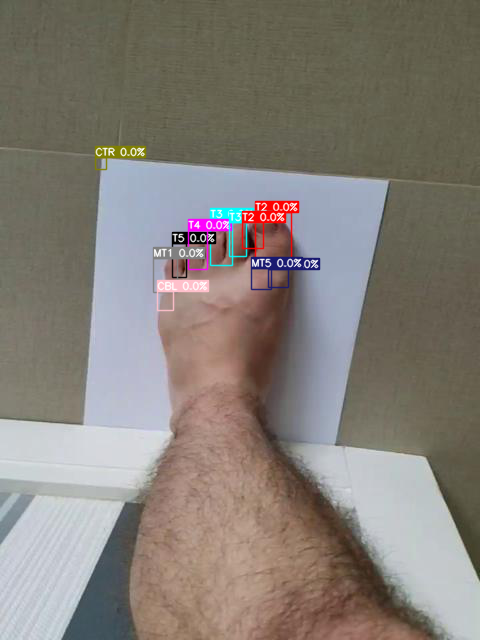

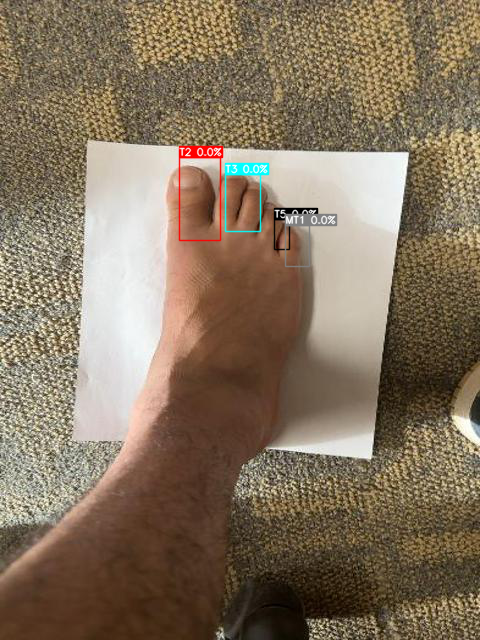

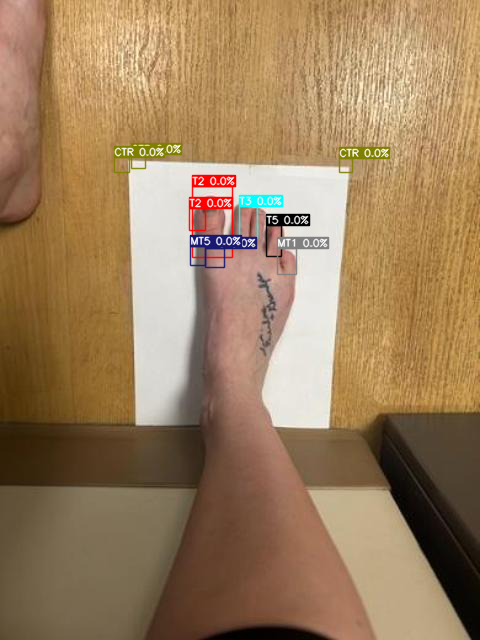

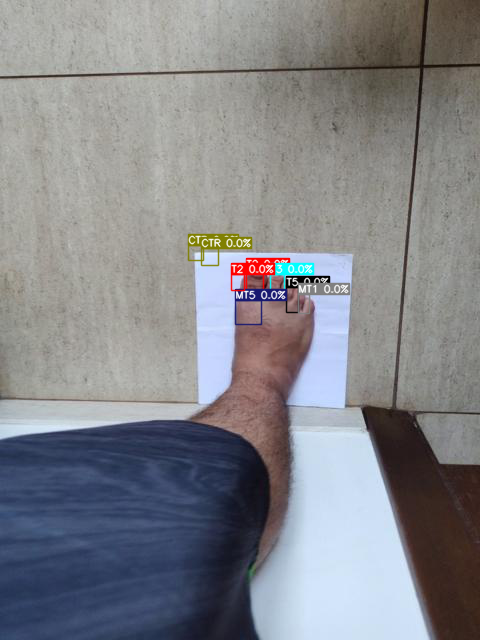

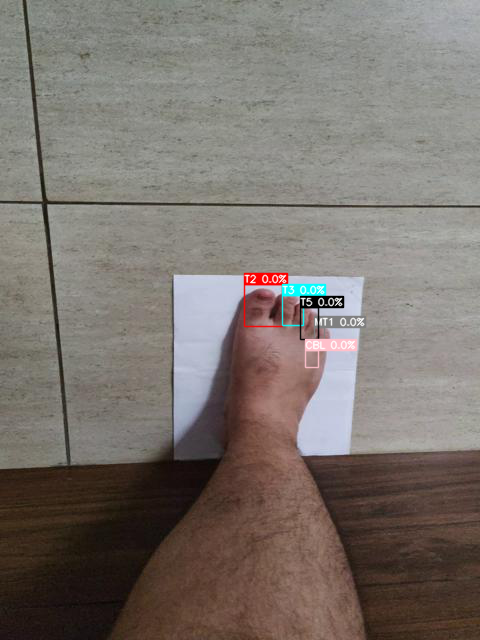

In [130]:
import object_detection_utils.visualizations as viz
import object_detection_utils.utils as ut

def plot_dataset_prediction(idx=0):
    curr_data = dataset_prediction[idx]
    curr_dict = {k:v.cpu().detach().numpy().tolist() for k,v in curr_data['y'].items()}

    labels_list = list(mapping.keys())
    curr_dict['labels'] = [labels_list[k] for k in curr_dict['labels']]
    x_name = curr_data['x_name']
    y_name = curr_data['y_name']

    temp_name = "curr_prped.json"
    temp_filepath = Path(ROOT_PATH) / Path(temp_name)
    ut.save_json(curr_dict,temp_filepath)

    viz.plot_bboxes_from_files(
        Path(parameters.DATA_DIR) / Path(x_name),
        temp_filepath,
        mapping = mapping,
    )

for i in range(0,5):
    plot_dataset_prediction(i)